In [214]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{torch.__version__} running on {device}")

2.4.0+cu121 running on cuda


# GP Run for Image Classification
Your problem needs to fulfill the following criteria.
1. It is an image classification problem.
2. You supply marked training images and marked validation images.

Within those, the run is flexible and adapts itself to your problem.
Now, please describe your images and problem by setting those global variables:

In [215]:
IMAGE_WIDTH = 28 # <-- number of width-pixels
IMAGE_HEIGHT = 28 # <-- number of height-pixels
COLOUR_CHANNEL_COUNT = 1 # <-- RGB images would have 3
CLASSIFICATION_CATEGORIES_COUNT = 10 # <-- the amount of possible categories of which each image shall be marked with one

### Prepare Example Data
To check the code, we prepare example data: Fashion MNIST.

In [216]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data (and not testing data)
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
print(f"train_data.classes = {train_data.classes}")

train_data.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [217]:
from torch.utils.data import DataLoader
MINI_BATCH_SIZE = 32 # constant for now

# Turn datasets into iterables (batches), shuffeling train data every epoch (test data not)
train_dl_f_mnist = DataLoader(train_data, batch_size=MINI_BATCH_SIZE, shuffle=True)
test_dl_f_mnist = DataLoader(test_data, batch_size=MINI_BATCH_SIZE, shuffle=False)

print(f"train_dl_f_mnist.batch_size = {train_dl_f_mnist.batch_size}") 
print(f"len(next(iter(train_dl_f_mnist))) = {len(next(iter(train_dl_f_mnist)))}") 
print(f"next(iter(train_dl_f_mnist))[0].shape = {next(iter(train_dl_f_mnist))[0].shape}") 
print(f"len(train_dl_f_mnist) = {len(train_dl_f_mnist)}, len(test_dl_f_mnist) = {len(test_dl_f_mnist)}")

train_dl_f_mnist.batch_size = 32
len(next(iter(train_dl_f_mnist))) = 2
next(iter(train_dl_f_mnist))[0].shape = torch.Size([32, 1, 28, 28])
len(train_dl_f_mnist) = 1875, len(test_dl_f_mnist) = 313


Image shape: torch.Size([1, 28, 28])


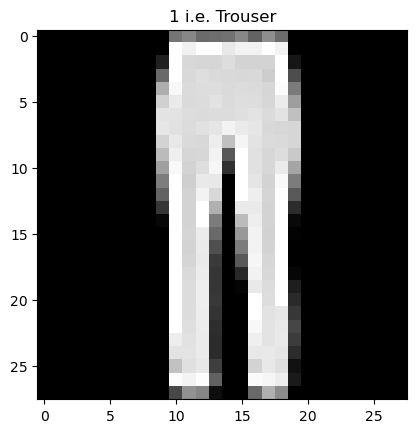

In [218]:
image_index = 2 # index in the batch, 0 .. 31
train_features_batch, train_labels_batch = next(iter(train_dl_f_mnist))
print(f"Image shape: {train_features_batch[image_index].shape}")
plt.imshow(train_features_batch[image_index].squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(str(train_labels_batch[image_index].item())+" i.e. "+train_data.classes[train_labels_batch[image_index].item()]);

## The Individuals' Class
- The Hyperparamters should be passed to the constructor in a way that is both convenient for GP and for PyTorch.
- I think I want to define a class for one `nn.Sequential` 2d-block
    - All possible instances should be concatenable with all possible instances
- Then, an individual is built from the concatenation of many such blocks, plus data preparation and final f.c. 2d_block

In [219]:
''' superseded later in the notebook...
class Sequential_block_2d(nn.Module):
    def __init__(self, 
                 out_channels: int, # the number of output neurons after the full block
                 in_channels: int = 1, # should not be set here, but is set in Individual's __init__()
                 conv_kernel_size: int = 3,
                 conv_stride: int = 1,
                 conv_padding: int = 1,
                 pool_kernel_size: int = 2,
                 pool_stride: int = 2,
                 pool_padding: int = 0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=conv_kernel_size,
                      stride=conv_stride,
                      padding=conv_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,
                         stride=pool_stride,
                         padding=pool_padding)
        )
    def forward(self, x):
        return self.block(x)

# generate some testing blocks (TODO: write actual unit tests)
testBlock1 = Sequential_block_2d(in_channels=1,out_channels=5)
testBlock2 = Sequential_block_2d(in_channels=5,out_channels=3)
torch.manual_seed(42)
'''
testX = torch.randn(COLOUR_CHANNEL_COUNT,IMAGE_WIDTH,IMAGE_HEIGHT).to(device)
'''
print(f"testX.shape = {testX.shape}\ntestX[:,:3]: {testX[:,:3]}")
print(f"testBlock1(testX).shape = {testBlock1(testX).shape}\ntestBlock1(testX)[:1,:3]: {testBlock1(testX)[:1,:3]}")
'''

'\nprint(f"testX.shape = {testX.shape}\ntestX[:,:3]: {testX[:,:3]}")\nprint(f"testBlock1(testX).shape = {testBlock1(testX).shape}\ntestBlock1(testX)[:1,:3]: {testBlock1(testX)[:1,:3]}")\n'

In [220]:
''' superseded later in the notebook...
# class for image classification individuals
class NN_individual(nn.Module):
    def __init__(self, blocks_2d: list[Sequential_block_2d],
                 in_dimensions: int = COLOUR_CHANNEL_COUNT,
                 out_dimensions: int = CLASSIFICATION_CATEGORIES_COUNT,
                 fin_res: int = 5): # output dimension of the final max pooling 
                                    # producing size (fin_res * fin_res)
        super().__init__()
        self.blocks_2d = blocks_2d
        # add a final max pool
        # Why? Because then torch handles the dimensions through the "adaptive"ness
        self.last_max_pool_adaptive = nn.AdaptiveAvgPool2d((fin_res, fin_res))
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1) # default start_dim = 1
        self.lin = nn.Linear(in_features = fin_res * fin_res * blocks_2d[-1].out_channels,
                      out_features = out_dimensions)
    def forward(self, x):
        for i in range(len(self.blocks_2d)):
            x = self.blocks_2d[i](x)
        x = self.last_max_pool_adaptive(x)
        print(f"last_max_pool_adaptive output shape is {x.shape}")
        x = self.flatten(x)
        print(f"flatten output shape is {x.shape}")
        x = self.lin(x)
        print(f"lin output shape is {x.shape}")
        return x
    
testIndividual = NN_individual(blocks_2d=[testBlock1, testBlock2])
testIndividual(testX)
'''

' superseded later in the notebook...\n# class for image classification individuals\nclass NN_individual(nn.Module):\n    def __init__(self, blocks_2d: list[Sequential_block_2d],\n                 in_dimensions: int = COLOUR_CHANNEL_COUNT,\n                 out_dimensions: int = CLASSIFICATION_CATEGORIES_COUNT,\n                 fin_res: int = 5): # output dimension of the final max pooling \n                                    # producing size (fin_res * fin_res)\n        super().__init__()\n        self.blocks_2d = blocks_2d\n        # add a final max pool\n        # Why? Because then torch handles the dimensions through the "adaptive"ness\n        self.last_max_pool_adaptive = nn.AdaptiveAvgPool2d((fin_res, fin_res))\n        self.flatten = nn.Flatten(start_dim=0, end_dim=-1) # default start_dim = 1\n        self.lin = nn.Linear(in_features = fin_res * fin_res * blocks_2d[-1].out_channels,\n                      out_features = out_dimensions)\n    def forward(self, x):\n        for 

In [221]:
''' superseded
# this way, adjacent genes (= 2d_blocks) need to have the correct dimensions
# e.g. the following will error:
badIndividual = NN_individual([Sequential_block_2d(in_channels=1,out_channels=2), Sequential_block_2d(in_channels=3, out_channels=5)])
try:
    print(badIndividual(testX))
except:
    print("out_channels of the first needs to match in_channels of the second!")

# but there's more redundancy:\the first gene needs to have the same number of in_channels as there are colour channels
# e.g. the following will error:
badIndividual = NN_individual([Sequential_block_2d(in_channels=COLOUR_CHANNEL_COUNT + 1,out_channels=5)])
try:
    print(badIndividual(testX))
except:
    print("in_channels of the first gene needs to match the COLOUR_CHANNEL_COUNT of the problem!")
'''

' superseded\n# this way, adjacent genes (= 2d_blocks) need to have the correct dimensions\n# e.g. the following will error:\nbadIndividual = NN_individual([Sequential_block_2d(in_channels=1,out_channels=2), Sequential_block_2d(in_channels=3, out_channels=5)])\ntry:\n    print(badIndividual(testX))\nexcept:\n    print("out_channels of the first needs to match in_channels of the second!")\n\n# but there\'s more redundancy:\the first gene needs to have the same number of in_channels as there are colour channels\n# e.g. the following will error:\nbadIndividual = NN_individual([Sequential_block_2d(in_channels=COLOUR_CHANNEL_COUNT + 1,out_channels=5)])\ntry:\n    print(badIndividual(testX))\nexcept:\n    print("in_channels of the first gene needs to match the COLOUR_CHANNEL_COUNT of the problem!")\n'

### Brainstorm on How to Encode Individuals
We need to talk about this right now because we want to adapt our `NN_individual.blocks_2d` definition according to it.
The options are:
1. We specify `Sequential_block_2d.in_channels` and `~.out_channels` separately for each individual and only allow concatenation if the criteria are met. This is probably not super clever...
2. Genotype-closure: The parameters that are adapted through GP will never leave the space of syntacticly correct indivuals
    - The first gene is not allowed to choose `~.in_channels`, it must match `COLOUR_CHANNEL_COUNT`
    - Every gene but the first is not allowed to choose `~.in_channels`, it must match `~.out_channels` of the prior gene
    - How will this change the gene class `Sequential_block_2d`?
        - Set `Sequential_block_2d.in_channels` only programatically, in `NN_individual.__init__()`
        - Don't even let the genes inherit from `nn.Module`, only the individual

In [222]:
''' Calculate the image size after a layer has been applied
    assume all operations to be x/y symmetric '''
def output_size(h_in, kernel_size, stride, padding):
    h_out = (h_in + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    #w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1
    return h_out # = w_out

# class for the genetic information of one 2d block
class Gene_2d_block:
    def __init__(self,
                 input_image_size: int,
                 out_channels: int,
                 conv_kernel_size: int = 3,
                 conv_stride: int = 1,
                 conv_padding: int = 1,
                 pool_kernel_size: int = 2,
                 pool_stride: int = 2,
                 pool_padding: int = 0):
        self.input_image_size = input_image_size
        self.out_channels = out_channels
        self.in_channels = None
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding

        self.after_conv_image_size = output_size(input_image_size, conv_kernel_size, conv_stride, conv_padding)
        self.output_image_size = output_size(self.after_conv_image_size, pool_kernel_size, pool_stride, pool_padding)

    def toString(self, tab_count: int = 0):
        indentation = ""
        for tab in range(tab_count): indentation += f"\t"
        return f"{indentation}out_channels = {self.out_channels} <-- ({self.input_image_size} x {self.input_image_size})\n"+\
        f"{indentation}conv_2d (kernel, stride, padding) =\t({self.conv_kernel_size}, {self.conv_stride}, {self.conv_padding}) --> ({self.after_conv_image_size} x {self.after_conv_image_size})\n"+\
        f"{indentation}max_pool_2d (kernel, stride, padding) =\t({self.pool_kernel_size}, {self.pool_stride}, {self.pool_padding}) --> ({self.output_image_size} x {self.output_image_size})"

print(Gene_2d_block(IMAGE_WIDTH, 3).toString())

out_channels = 3 <-- (28 x 28)
conv_2d (kernel, stride, padding) =	(3, 1, 1) --> (28 x 28)
max_pool_2d (kernel, stride, padding) =	(2, 2, 0) --> (14 x 14)


In [223]:
''' this is supserseded below...
# class for image classification individuals
class NN_individual(nn.Module):
    def __init__(self, genes_2d_block: list[Gene_2d_block], name="nn0"): 
        super().__init__()
        self.name=name # a name for easier tracking inside a GP run
        # build the full sequential from the gene information (genes_2d_block)
        self.blocks_2d = nn.Sequential()
        # the first 2d_block needs to have as many in_channels as there are colour channels
        # the others need to have as in_channels the number of out_channels from the previous block
        for i in range(len(genes_2d_block)):
            if i == 0:
                in_channels = COLOUR_CHANNEL_COUNT
            else:
                in_channels = genes_2d_block[i-1].out_channels
            self.blocks_2d.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                    out_channels=genes_2d_block[i].out_channels,
                    kernel_size=genes_2d_block[i].conv_kernel_size,
                    stride=genes_2d_block[i].conv_stride,
                    padding=genes_2d_block[i].conv_padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=genes_2d_block[i].pool_kernel_size,
                    stride=genes_2d_block[i].pool_stride,
                    padding=genes_2d_block[i].pool_padding)))
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1) # default start_dim = 1
        self.lazyLin = nn.LazyLinear(out_features = CLASSIFICATION_CATEGORIES_COUNT) # automatically infers the number of channels
    def forward(self, x):
        for i in range(len(self.blocks_2d)):
            x = self.blocks_2d[i](x)
        x = self.flatten(x)
        #print(f"flatten output shape is {x.shape}")
        x = self.lazyLin(x)
        #print(f"lin output shape is {x.shape}")
        return x
    
testIndividual = NN_individual(genes_2d_block=[Gene_2d_block(out_channels=4), Gene_2d_block(out_channels=7)])
testIndividual, testIndividual(testX)
'''

' this is supserseded below...\n# class for image classification individuals\nclass NN_individual(nn.Module):\n    def __init__(self, genes_2d_block: list[Gene_2d_block], name="nn0"): \n        super().__init__()\n        self.name=name # a name for easier tracking inside a GP run\n        # build the full sequential from the gene information (genes_2d_block)\n        self.blocks_2d = nn.Sequential()\n        # the first 2d_block needs to have as many in_channels as there are colour channels\n        # the others need to have as in_channels the number of out_channels from the previous block\n        for i in range(len(genes_2d_block)):\n            if i == 0:\n                in_channels = COLOUR_CHANNEL_COUNT\n            else:\n                in_channels = genes_2d_block[i-1].out_channels\n            self.blocks_2d.append(nn.Sequential(\n                nn.Conv2d(in_channels=in_channels,\n                    out_channels=genes_2d_block[i].out_channels,\n                    kernel_s

## GP Code
Now we need to decide the genetic stuff.
1. Initial Population
2. Fitness Measure
3. Selection
4. Genetic Operators
    - Cloning or Crossover
    - Mutation
    
### Hyperparameter-landscape is vast. Here's a list:
- Net architecture
    - kind of layers, number of layers
        - for convolution/pooling: kernel size, stride, padding, (dilation) **[implemented]**
    - number of neurons per layer
    - activation function for each layer
- cost function
    - base term (e.g. square cost, log-likelihood, cross-entropy, ect.)
    - toppings 
        - regularization of weights (L2, L1, dropout, etc.)
- weights and biases optimization technique (= optimizer)
    - SGD (= stochastic gradient descent)
    - Hessian technique, i.e. momentum-based descent
    - PyTorch's various other (e.g. *Adam* optimizer)
- learning parameters
    - η ... learning rate
        - constant, or epoch-dependent, or accuracy-dependent, or a mix
    - \# of epochs
        - constant, or early stopping
    - (`mini_batch_size` - this one might be canonical)

### Encode Within-One-Gen-Constant Hyperparameters in `NN_individual`
We now bake:
- the individual-specific, hyperparameters (that don't change within one gen)
- the fitness dictionaries

into parameters of the `NN_individual` class.

We construct this class from a `NN_dna` class that contains all the genetic information necessary to build the `NN_individual`.

In [224]:
# class containing various genes (with their vanilla values) and the G2P mappings
class NN_dna():
    def __init__(self,
                 blocks_2d: list[Gene_2d_block] = [],
                 optimizer: int = 0,
                 lr: float = .1,
                 loss_fn: int = 0,
                 ) -> None:
        self.blocks_2d_gene = blocks_2d
        self.optimizer_gene = optimizer
        self.lr = lr
        self.loss_fn_gene = loss_fn
    
    #### Genotype To Phenotype Mappings (G2P) ####
    def blocks_2d_G2P(self):
        ''' build 'n return the full sequential from the gene information (genes_2d_block) 
            the first 2d_block needs to have as many in_channels as there are colour channels
            the others need to have as in_channels the number of out_channels from the previous block
            there's a nn.Module (Lazy*) that automatically infers the number of in_channels - not used here '''
        blocks_2d = nn.Sequential()
        for i in range(len(self.blocks_2d_gene)):
            if i == 0:
                in_channels = COLOUR_CHANNEL_COUNT
            else:
                in_channels = self.blocks_2d_gene[i-1].out_channels
            blocks_2d.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                    out_channels=self.blocks_2d_gene[i].out_channels,
                    kernel_size=self.blocks_2d_gene[i].conv_kernel_size,
                    stride=self.blocks_2d_gene[i].conv_stride,
                    padding=self.blocks_2d_gene[i].conv_padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=self.blocks_2d_gene[i].pool_kernel_size,
                    stride=self.blocks_2d_gene[i].pool_stride,
                    padding=self.blocks_2d_gene[i].pool_padding)))
        return blocks_2d
        
    optimizer_dict = {0: "SGD", 1: "adam"}
    def optimizer_G2P(self, model_parameters):
        if self.optimizer_gene == 0: return torch.optim.SGD(model_parameters, lr=self.lr)
        if self.optimizer_gene == 1: return torch.optim.Adam(model_parameters, lr=self.lr)
        raise ValueError(f"'{self.optimizer_gene}' is not a gene for which we have an optimizer encoded.")
    
    loss_fn_dict = {0: "CrossEn", 1: "L1", 2: "Huber"}
    def loss_fn_G2P(self):
        if self.loss_fn_gene == 0: return nn.CrossEntropyLoss()
        if self.loss_fn_gene == 1: return nn.L1Loss()
        if self.loss_fn_gene == 2: return nn.HuberLoss()
        raise ValueError(f"'{self.loss_fn_gene}' is not a gene for which we have a loss function encoded.")

In [225]:
''' class for image classification individuals
    Essentially, it converts NN_dna (provided to __init__)
    into a working NN with a forward method
'''
class NN_individual(nn.Module):
    def __init__(self, 
                 dna: NN_dna = NN_dna(),    # <- contains all genes
                 name: str = "nn0",         # <- name unique within a population/generation
                 device = device):
        super().__init__()
        self.dna = dna
        self.blocks_2d = dna.blocks_2d_G2P()
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1) # default is: start_dim = 1
        self.lazyLin = nn.LazyLinear(out_features = CLASSIFICATION_CATEGORIES_COUNT) # automatically infers the number of channels
        self.name = name
        self.lr = dna.lr
        self.optimizer = dna.optimizer_G2P(self.parameters())
        self.loss_fn = dna.loss_fn_G2P()
        self.to(device)
        self.device = device

        self.acc = 0
        self.running_acc = 0
        self.train_losses = {}
        self.test_losses = {}
        self.accs = {}
        self.elapsed_training_time = 0
        
    def forward(self, x):
        for i in range(len(self.blocks_2d)):
            x = self.blocks_2d[i](x)
        x = self.flatten(x)
        x = self.lazyLin(x)
        return x
    
testIndividual = NN_individual()#genes_2d_block=[Gene_2d_block(out_channels=4), Gene_2d_block(out_channels=7)])
testIndividual, testIndividual(testX)

(NN_individual(
   (blocks_2d): Sequential()
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (lazyLin): Linear(in_features=784, out_features=10, bias=True)
   (loss_fn): CrossEntropyLoss()
 ),
 tensor([[-0.5065, -0.0216,  0.2096,  0.9886, -0.4051, -0.7625, -0.8564, -0.0976,
          -0.5313, -0.0121]], device='cuda:0', grad_fn=<AddmmBackward0>))

### Visualize, Visualize, Visualize
Create a class called population of which an instance acts as an array of `NN_individual`s with extra functionality that regards the whole population.

In [226]:
# created by Chat
class NN_population:
    ### Magic Methods ###
    def __init__(self, individuals: list[NN_individual]): self.individuals = individuals
    def __getitem__(self, index): return self.individuals[index]  # magic pop[i] access
    def __len__(self): return len(self.individuals)  # magic len(pop)
    def __setitem__(self, index, value): self.individuals[index] = value  # magic pop[i] = value
    def __iter__(self): return iter(self.individuals)  # magic for-iterations
    
    def plot_accs(self, elapsed_time = 0):
        plt.figure(figsize=(15, 6))  # Set the figure size
        for ind in self.individuals:
            x = list(ind.accs.keys())  # Extract the epoch/batch labels (x-axis)
            y = [float(val.cpu().item()*100) for val in ind.accs.values()]  # Convert tensors to floats
            # Plot each individual's accuracies
            plt.plot(x, y, marker='o', linestyle='-', label=f"{ind.name} ({ind.elapsed_training_time:.1f}s, running acc {ind.running_acc:.2f})")
        plt.xlabel('Epoch@Batch')  # Label for the x-axis
        plt.ylabel('Accuracy [%]')     # Label for the y-axis
        extra_title = "" if elapsed_time == 0 else f" (took {elapsed_time:.2f}s)"
        plt.title('Accuracy per Epoch and Batch' + extra_title)  # Title of the plot
        plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
        plt.grid(True)  # Show grid
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # legend on the right
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust plot area size to leave space for the legend
        plt.show()

### Create Random Population

In [227]:
import random

def create_random_2d_block(input_image_size, max_kernel_size: int) -> Gene_2d_block:
    conv_kernel_size=min(random.randint(1,min(input_image_size, max_kernel_size)), random.randint(1,min(input_image_size, max_kernel_size))) # kernel must be smaller than image size!
    conv_stride=random.randint(1,conv_kernel_size)
    conv_padding=random.randint(0,conv_kernel_size//2) # PyTorch: "pad should be at most half of effective kernel size"
    after_conv_i_s = output_size(input_image_size, conv_kernel_size, conv_stride, conv_padding)
    pool_kernel_size=min(random.randint(1,min(after_conv_i_s, max_kernel_size)), random.randint(1,min(after_conv_i_s, max_kernel_size)), random.randint(1,min(after_conv_i_s, max_kernel_size)))
    if conv_kernel_size == 0 or pool_kernel_size == 0:
        print("Exception! A kernel size is 0, which is not allowed.")
        print(f"input_image_size {input_image_size}, max_kernel_size {max_kernel_size}, conv_kernel_size {conv_kernel_size}, conv_stride {conv_stride}, conv_padding {conv_padding}, after_conv_image_size {after_conv_i_s}, pool_kernel_size {pool_kernel_size}")
    pool_stride=max(random.randint(1,pool_kernel_size), random.randint(1,pool_kernel_size))
    pool_padding=random.randint(0,pool_kernel_size//2) # PyTorch: "pad should be at most half of effective kernel size"
    return Gene_2d_block(
        input_image_size=input_image_size,
        out_channels=random.randint(3,15), # not fine-tuned
        conv_kernel_size=conv_kernel_size,
        conv_padding=conv_padding,
        conv_stride=conv_stride,
        pool_kernel_size=pool_kernel_size,
        pool_padding=pool_padding,
        pool_stride=pool_stride
    )

def update_and_check_2d_block_stack(gene_2d_blocks: list[Gene_2d_block]):
    protocol = ""
    if len(gene_2d_blocks) == 0: return "no block in the stack"
    if gene_2d_blocks[0].input_image_size != IMAGE_HEIGHT:
        gene_2d_blocks[0].input_image_size != IMAGE_HEIGHT
        protocol += f"block[0]'s input_image_size was set to IMAGE_HEIGHT ({IMAGE_HEIGHT}), " 
    for i, block in enumerate(gene_2d_blocks):
        if i > 0 and block.input_image_size != gene_2d_blocks[i-1].output_image_size:
            block.input_image_size = gene_2d_blocks[i-1].output_image_size
            protocol += f"block[{i}]'s input_image_size was set to block[{i-1}]'s output_image_size ({block.input_image_size}), "
            block.after_conv_image_size = output_size(block.input_image_size, block.conv_kernel_size, block.conv_stride, block.conv_padding) # update the effective image size after convolution
        if block.input_image_size < block.conv_kernel_size:
            block.conv_kernel_size = block.input_image_size
            protocol += f"block[{i}]'s conv_kernel_size was decreased to input_image_size ({block.conv_kernel_size}), "
        if block.conv_padding > block.conv_kernel_size // 2:
            block.conv_padding = block.conv_kernel_size // 2
            protocol += f"block[{i}]'s conv_padding was decreased to conv_kernel_size//2 ({block.conv_kernel_size // 2}), "
        if block.after_conv_image_size < block.pool_kernel_size:
            block.pool_kernel_size = block.after_conv_image_size
            protocol += f"block[{i}]'s pool_kernel_size was decreased to after_conv_size ({block.pool_kernel_size}), "
        if block.pool_padding > block.pool_kernel_size // 2:
            block.pool_padding = block.pool_kernel_size // 2
            protocol += f"block[{i}]'s pool_padding was decreased to pool_kernel_size//2 ({block.pool_kernel_size // 2}), "
    return protocol
    
def create_random_population(pop_size: int, 
                             max_2d_block_count: int = 3, 
                             max_kernel_size: int = 11,
                             name_prefix="nn",
                             device="cpu",
                             print_summary: bool = True) -> NN_population:
    population = []
    for i in range(pop_size):
        genes_2d_block = []
        input_image_size = IMAGE_HEIGHT # = IMAGE_WIDTH (assumed)
        name=name_prefix+str(i)
        if print_summary: print(f"Individual '{name}' <-- ({input_image_size} x {input_image_size})")
        for j in range(random.randint(1, max_2d_block_count)):
            if print_summary: print(f"\tBlock {j}")
            # create a random conv-pool block and store the corresponding new input_image_size for the block thereafter
            block = create_random_2d_block(input_image_size, max_kernel_size)
            input_image_size = block.output_image_size
            genes_2d_block.append(block)
            if print_summary: print(f"{block.toString(tab_count=2)} --> ({input_image_size} x {input_image_size})")
        dna = NN_dna(blocks_2d=genes_2d_block,
                    # here you can change the remaining hyperparameters
                    )
        population.append(NN_individual(dna=dna, name=name, device=device))
    return NN_population(population)
testPop = create_random_population(pop_size=7, max_2d_block_count=3, print_summary=False)
try:
    for ind in testPop:
        ind.eval()
        with torch.inference_mode():
            ind(testX)
except:
    print("oh, oh! exception")

oh, oh! exception


### Fitness Evaluation
We want a population that:
- achieves high (validation/test data) accuracy after training
    - the final accuracy `acc(NN1(t_final))` of an individual `NN1` is used
- trains fast, i.e. takes little CPU time to achieve high accuracy called **Running Accuracy**
    - the individual's accuracy `acc(NN1(t))` is summed over given timestamps `t`, like `Σ_t{acc(NN1(t))}`
    - possibly we want to value early accuracy more, summing `Σ_t{acc(NN1(t))/t}` instead

In [228]:
import torchmetrics
from torchmetrics import functional
import time

In [229]:
def train_model_one_batch(ind: NN_individual, # <- model to be trained in-place
                          X, y,               # <- train batch, e.g. X.shape = [32, 1, 28, 28]
                          ) -> tuple[float, float]:
  train_loss = 0
  start_time = time.perf_counter() # Start timing
  ind.train()
  X, y = X.to(ind.device), y.to(ind.device)
  y_pred = ind(X)
  loss = ind.loss_fn(y_pred, y)
  train_loss += loss
  ind.optimizer.zero_grad()
  loss.backward()
  ind.optimizer.step()
  end_time = time.perf_counter() # Stop timing
  return (train_loss, end_time-start_time)

def test_model(ind: NN_individual,            # <- model to be tested
               test_dl,                       # <- test dataloader (= multiple batches)
               ) -> tuple[float, float]:      # -> return (loss_total, acc_total)
  loss_total, acc_total = 0, 0
  ind.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dl):
      X, y = X.to(ind.device), y.to(ind.device)
      preds = ind(X)
      loss_batch = ind.loss_fn(preds, y)
      loss_total += loss_batch
      acc_batch = functional.accuracy(preds, y, task="multiclass", num_classes=CLASSIFICATION_CATEGORIES_COUNT)
      acc_total += acc_batch

    loss_total /= len(test_dl)
    acc_total /= len(test_dl)
  return (loss_total, acc_total)

We now train the whole population simultaneously, populating the individuals' fitness value parameters:
- `train_losses` ... a dictionary filled with the train loss function results for each batch (independent of how often we test, because it comes for free)
- `test_losses` ... same as above but evaluating on test data instead, and only whenever we choose to test (obviously; this is not free)
- `accs` ... a dictionary with same keys as `test_losses`, filled with the fraction of correct model predictions by total number of predictions
- `acc` ... a single number - the most recent accuracy (defined similarly as `accs`)
- `running_acc` ... a single number - the sum of all known accuracies (i.e. at all times where we tested), divided by the time
    - here, we exclude the first accuracy because the division is very big in that case, and accuracy only depends mainly on weight initialization

In [230]:
from tqdm import tqdm
from torch.utils.data import Subset
from IPython.display import clear_output

def train_and_evaluate_gen(pop: NN_population,
                           train_dl,  # <- train dataloader
                           test_dl,   # <- test dataloader
                           testing_interval = 300,      # <- after how many batches should we test an individual
                           testing_data_fraction = 1.0, # <- amount of test_dl to be used (1=100% takes a lot of time)
                           epochs = 5,
                           live_plot = True,
                           only_last_plot = False,
                           no_plot = False):
  start_time = time.perf_counter() # Start timing

  # prepare the reduced testing data loader
  total_batches = len(test_dl)
  num_batches_to_sample = int(total_batches * testing_data_fraction) # number of batches to select
  random_batch_indices = random.sample(range(total_batches), num_batches_to_sample) # random indices (without replacement)
  test_subset = Subset(test_dl.dataset, random_batch_indices)
  test_subset_dl = DataLoader(test_subset, batch_size=test_dl.batch_size, shuffle=False, num_workers=test_dl.num_workers)

  # re-initialize pop's fitness values:
  for ind in pop:
    ind.acc, ind.running_acc = 0, 0
    ind.train_losses, ind.test_losses, ind.accs = {}, {}, {}
  
  # train each individual "simultaneously" by making the epoch-loop the outer one
  for epoch in range(epochs):
    print(f"*** Commencing epoch {epoch+1} / {epochs} for {len(pop)} individuals, one line each. ***")
    for i in range(len(pop)):
      #print(f"Training {pop[i].name} for {len(train_dl)} batches (of size {train_dl.batch_size}): ", end='')
      for batch, (X, y) in tqdm(enumerate(train_dl),desc=f"{i+1}. {pop[i].name}"):
        # train the model (update the weights and biases of the NN pop[i])
        pop[i].train_losses[f"e_{epoch}@b_{batch}"], elapsed_batch_training_time = train_model_one_batch(pop[i], X=X, y=y)
        pop[i].elapsed_training_time += elapsed_batch_training_time
        if batch % testing_interval == 0: 
          # test the model and store the results
          pop[i].test_losses[f"e_{epoch}@b_{batch}"], pop[i].accs[f"e_{epoch}@b_{batch}"] = test_model(pop[i], test_dl=test_subset_dl)
          if batch != 0: # don't use the start/benchmark test as this depends mostly on luck of weight initialization
            pop[i].running_acc += pop[i].accs[f"e_{epoch}@b_{batch}"] / pop[i].elapsed_training_time
          if live_plot and not only_last_plot and not no_plot:
            clear_output(wait=True)
            pop.plot_accs(time.perf_counter() - start_time)
      pop[i].test_losses[f"e_{epoch}@end"], pop[i].accs[f"e_{epoch}@end"] = test_model(pop[i], test_dl=test_dl) # latest precise values
      pop[i].acc = pop[i].accs[f"e_{epoch}@end"] # store the very last known accuracy
      if not live_plot and not only_last_plot and not no_plot:
        clear_output(wait=True)
        pop.plot_accs(time.perf_counter() - start_time)
    # here we could select directly, i.e. before the whole train_dl over max_epochs no. of iterations has been trained

  if not no_plot and not only_last_plot:
    clear_output(wait=True)
    pop.plot_accs(time.perf_counter() - start_time)
  elif not no_plot and only_last_plot:
    pop.plot_accs(time.perf_counter() - start_time)
  else:  
    print(f"This took {time.perf_counter() - start_time:.2f}s.")
      

### Test with Example Data
Use the example dataloaders to populate the fitness values for a generation.

In [231]:
pop = create_random_population(pop_size=4, max_2d_block_count=4, max_kernel_size=7, name_prefix="gen0.", device=device, print_summary=False)
pop[0].device

'cuda'

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

columns=['a','b','c']
data = np.cumsum(np.random.rand(10,3),axis=1)
df = pd.DataFrame(data,columns=columns)

def g(x,y):
    plt.scatter(df[x], df[y])
    plt.show()

interactive_plot = interactive(g, x=columns, y=columns)
interactive_plot


interactive(children=(Dropdown(description='x', options=('a', 'b', 'c'), value='a'), Dropdown(description='y',…

In [233]:
#train_and_evaluate_gen(pop, train_dl_f_mnist, test_dl_f_mnist, testing_interval=200, epochs=1, testing_data_fraction=.1, live_plot=False)

### Mutate
Should be guided by randomness, and not too radical.
1. Fix a bound of *radicalities* fixed at 1.
2. Each possible operation of mutation needs to come with a *factor of impact* **λ**
    - e.g. delete/add 2d block: **λ = 5**
    - e.g. learning rate times 1.1: **λ = 0.5**
3. Now we spin the wheels for each call of `mutate_individual`:
    - random radicality **0 < R < 1**
    - random raw likelihood **0 < p < 1** for each possible operation
    - execute an operation iff **λ•p < R** where **λ** and **p** correspond to the operation in question

In [234]:
MAX_KERNEL_SIZE = 11
class Mutation():
    def __init__(self):
        self.R = random.random() # <- radicality of this mutation instance

    ### factors of impact ###
    impact_lr_factor_1_1=.3
    impact_lr_factor_10=3
    impact_add_neuron_to_2d_block=1
    impact_delete_neuron_from_2d_block=1
    impact_add_2d_block=5
    impact_delete_2d_block=5
    impact_increase_kernel=.8
    impact_decrease_kernel=.8
    impact_change_optimizer=10
    impact_change_loss_fn=10

    ### possible operations (p_raw = 0 will happen most likely, p_raw = 1 least likely, p_raw = -1 definitely) ###
    def lr_factor_1_1(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_lr_factor_1_1 < self.R:
            if random.random() > .5:
                dna.lr *= 1.1
                return "multiplied lr by 1.1"
            else:
                dna.lr /= 1.1
                return "divided lr by 1.1"
    def lr_factor_10(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_lr_factor_10 < self.R:
            if random.random() > .5:
                dna.lr *= 10
                return "multiplied lr by 10"
            else:
                dna.lr /= 10
                return "divided lr by 10"
    def add_neuron_to_2d_block(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_add_neuron_to_2d_block < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            dna.blocks_2d_gene[layer_nr].out_channels += 1
            return f"added neuron to 2d block no. {layer_nr}"
    def delete_neuron_from_2d_block(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_delete_neuron_from_2d_block < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            if dna.blocks_2d_gene[layer_nr].out_channels > 1: dna.blocks_2d_gene[layer_nr].out_channels -= 1
            return f"deleted neuron from 2d block no. {layer_nr}"
    def add_2d_block(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_add_2d_block < self.R:
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene) + 1)
            input_image_size = IMAGE_WIDTH if layer_nr == 0 else dna.blocks_2d_gene[layer_nr-1].output_image_size
            dna.blocks_2d_gene.insert(layer_nr, create_random_2d_block(input_image_size, MAX_KERNEL_SIZE))
            # check whether this insertion "killed" the entity (and if yes: repair it)
            protocol = update_and_check_2d_block_stack(dna.blocks_2d_gene)
            return f"added 2d block at {layer_nr} + {protocol}"
    def delete_2d_block(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_delete_2d_block < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            dna.blocks_2d_gene.pop(layer_nr)
            # check whether this deletion "killed" the entity (and if yes: repair it)
            protocol = update_and_check_2d_block_stack(dna.blocks_2d_gene)
            return f"deleted 2d block at {layer_nr} + {protocol}"
    def increase_kernel(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_increase_kernel < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            if random.random() > .5:
                # check whether the kernel may be increased
                if dna.blocks_2d_gene[layer_nr].conv_kernel_size < dna.blocks_2d_gene[layer_nr].input_image_size:
                    dna.blocks_2d_gene[layer_nr].conv_kernel_size += 1
                    return f"conv kernel += 1 of 2d block no. {layer_nr}"
            else:
                if dna.blocks_2d_gene[layer_nr].pool_kernel_size < dna.blocks_2d_gene[layer_nr].after_conv_image_size:
                    dna.blocks_2d_gene[layer_nr].pool_kernel_size += 1
                    return f"pool kernel +=1 of 2d block no. {layer_nr}"
    def decrease_kernel(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_decrease_kernel < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            if random.random() > .5:
                if dna.blocks_2d_gene[layer_nr].conv_kernel_size > 1 and dna.blocks_2d_gene[layer_nr].conv_padding*2 < dna.blocks_2d_gene[layer_nr].conv_kernel_size:
                    dna.blocks_2d_gene[layer_nr].conv_kernel_size -= 1
                    return f"conv kernel -= 1 of 2d block no. {layer_nr}"
            else:
                if dna.blocks_2d_gene[layer_nr].pool_kernel_size > 1 and dna.blocks_2d_gene[layer_nr].pool_padding*2 < dna.blocks_2d_gene[layer_nr].pool_kernel_size:
                    dna.blocks_2d_gene[layer_nr].pool_kernel_size -= 1
                    return f"pool kernel -= 1 of 2d block no. {layer_nr}"
    def change_optimizer(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_change_optimizer < self.R:
            optimizer_index = random.randrange(0, len(NN_dna.optimizer_dict))
            dna.optimizer_gene = optimizer_index
            return f"changed optimizer to {NN_dna.optimizer_dict[optimizer_index]}"
    def change_loss_fn(self, dna: NN_dna, p_raw: float = -1):
        if p_raw * self.impact_change_loss_fn < self.R:
            loss_fn_index = random.randrange(0, len(NN_dna.loss_fn_dict))
            dna.loss_fn_gene = loss_fn_index
            return f"changed loss function to {NN_dna.loss_fn_dict[loss_fn_index]}"

def mutate_dna(dna: NN_dna, print_actions: bool = True, mutant_name = "NN") -> NN_dna:
    # create a mutation instance (this produces a radicality R)
    m = Mutation()
    if print_actions: print(f"Radicality in creation of '{mutant_name}': {m.R:.2g}")

    # Dynamically loop over all functions of the Mutation class
    for method_name in dir(m): # Loop through all attributes of the class
        if callable(getattr(m, method_name)) and not method_name.startswith("__"): # Filter to only functions (ignoring private methods and attributes)
            p_raw = random.random() # raw likelihood
            operation = getattr(m, method_name)
            effect = operation(dna, p_raw) # execute the operation
            if effect != None and print_actions: print(f"- {effect}")
    return dna # return new dna to simplify usage of this function

### GP Run
1. Create a random population of given POP_SIZE
2. `train_and_evaluate_gen` for one epoch
3. choose the half of `NN_individual`s that has the best `running_acc`
4. mutate each chosen NN **twice**
5. continue at *2.* unless you are already at gen FINAL_GEN

In [ ]:
POP_SIZE = 6
FINAL_GEN = 4
MAX_2D_BLOCK_COUNT = 7
MAX_KERNEL_SIZE = 11

testing_interval = 300
epochs = 1
testing_data_fraction = .5

gens = []
pop = create_random_population(POP_SIZE, max_2d_block_count=MAX_2D_BLOCK_COUNT, max_kernel_size=MAX_KERNEL_SIZE, name_prefix="NN", device=device, print_summary=False)
gens.append(pop)
for gen in range(FINAL_GEN):
    print(f"***** Gen. {gen+1} / {FINAL_GEN} *****")
    train_and_evaluate_gen(pop, train_dl_f_mnist, test_dl_f_mnist, testing_interval, testing_data_fraction, epochs=epochs, live_plot=False, only_last_plot=True)
    # only let the top half (w.r.t. running_acc) survive
    survivors = sorted(pop, key=lambda ind: ind.running_acc, reverse=True)[:len(pop) // 2]
    # mutate each survivor twice
    pop = NN_population([NN_individual(mutate_dna(ind.dna, mutant_name=ind.name+"."+v), name=ind.name+"."+v, device=device) for ind in sorted(survivors, key=lambda ind: ind.name) for v in ['a','b']])
    gens.append(pop)
train_and_evaluate_gen(pop, train_dl_f_mnist, test_dl_f_mnist, testing_interval, testing_data_fraction, epochs=epochs, live_plot=False, only_last_plot=True)
print(f"******* SUMMARY *******")
sorted(NN_population([gens[i][j] for i in range(len(gens)) for j in range(len(gens[i]))]), key=lambda ind: ind.running_acc).plot_accs()



***** Gen. 1 / 4 *****
*** Commencing epoch 1 / 1 for 6 individuals, one line each. ***


1. NN0: 231it [00:01, 142.88it/s]

In [190]:
# trying to spot the problem
ind = [ind for ind in pop.individuals if ind.name=="NN1.a.b"][0]
ind2 = [ind for ind in gens[0].individuals if ind.name=="NN0"][0]
for block in ind.dna.blocks_2d_gene:
    print(f"{block.toString()}\n")
#ind, ind2
# problem: a adding/deleting 2d blocks messes up the input_image_size

out_channels = 5 <-- (28 x 28)
conv_2d (kernel, stride, padding) =	(3, 3, 0) --> (9 x 9)
max_pool_2d (kernel, stride, padding) =	(2, 1, 0) --> (9 x 9)

out_channels = 12 <-- (9 x 9)
conv_2d (kernel, stride, padding) =	(3, 4, 0) --> (1 x 1)
max_pool_2d (kernel, stride, padding) =	(0, 1, 0) --> (6 x 6)

